Populating the interactive namespace from numpy and matplotlib


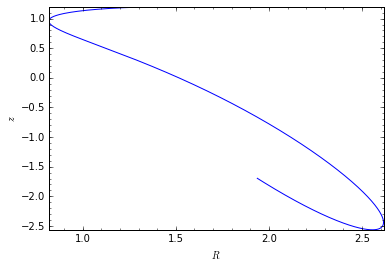

In [1]:
%pylab inline
import numpy            as     np
import matplotlib.pylab as     plt
from   galpy.util       import bovy_coords
from   galpy            import potential
from   galpy.orbit      import Orbit
from   galpy            import util


#----------------------------------------------------------
#               Coordinate Transformation
#----------------------------------------------------------

distance = 8.0 # kpc, distance to the stream

M      = np.zeros((3,3))
M[0,:] = [-0.4776303088,-0.1738432154,0.8611897727]
M[1,:] = [ 0.510844589 ,-0.8524449229,0.111245042 ]
M[2,:] = [ 0.7147776536, 0.4930681392,0.4959603976]

def phi12_to_radec(phi1,phi2,degree=False):
    
    """
    Parameters
    ----------------------------------------------------
        phi1   : stream coordinate
        phi2   : stream coordinate
        degree : if True, phi1 and phi2 are in degrees 
                 and will be converted to radians
    
    Functionality
    ----------------------------------------------------
        Using Appendix of Koposov 2010 A = M^-1.C,
        where inverse of M is the same as M transpose
    
    Return
    ----------------------------------------------------
        array[Declination,Right ascension]
    
    """
    
    C = np.array([np.cos(phi2)*np.cos(phi1),
                  np.cos(phi2)*np.sin(phi1),
                  np.sin(phi2)])
                  
    MC_dot = np.dot(M.T,C)
    dec    = np.arcsin(MC_dot[2])
    ra     = np.arctan2(MC_dot[1],MC_dot[0])
    
    if ra < 0.:
        ra += 2.*np.pi
    
    if degree == True:
        dec *= 180./np.pi
        ra  *= 180./np.pi
    return np.array([dec,ra])


def radec_to_xyz(dec,ra,d,degree=False):
    
    """
    Parameters
    ----------------------------------------------------
        dec    : stream coordinate
        ra     : stream coordinate
        d      : distance to the stream
        degree : if True, RA and DEC are in degrees and
                 will be converted to radians
        
    Functionality
    ----------------------------------------------------
        Using spherical coordinate transformation
        
    Return
    ----------------------------------------------------
        array[x,y,z]
    """
    
    if degree == True:
        dec *= np.pi/180.
        ra  *= np.pi/180.
    
    x = d * np.cos(dec) * np.cos(ra)
    y = d * np.cos(dec) * np.sin(ra)
    z = d * np.sin(ra)

    return np.array([x,y,z])


def xyz_to_cyl(x,y,z):
    
    """
    Parameters
    ----------------------------------------------------
        x,y,z : Cartesian coordinates
        
        
    Functionality
    ----------------------------------------------------
        Using equation for conversion of cartesian 
        coordinates to cylindrical
        
    Return
    ----------------------------------------------------
        array[R,z,phi]
    """

    
    R   = np.sqrt((x**2) + (y**2))
    phi = np.arctan(y/x)
    return np.array([R,z,phi])



#----------------------------------------------------------
#                  Velocity Transformation
#----------------------------------------------------------

def deriv(phi1,phi2,v_phi1,v_phi2,A,B,C,deg_type=False):
  
    """
    Parameters
    ----------------------------------------------------
        phi1, phi2     : stream coordinates
        v_phi1, v_phi2 : proper motion in stream 
                         coordinates
        A,B,C          : Matrix M row values which are 
                         the coefficients of the dot 
                         product of the M.C matrices
        
    Return
    ----------------------------------------------------
        Derivative of each row of matrix M * C
    """

# convert angles to radians for the sin and cos functions
    if deg_type == True:
        phi1 *= np.pi/180.
        phi2 *= np.pi/180.
    
    val1 = -A * ((np.sin(phi1) * np.cos(phi2) * v_phi1) + (
                 (np.cos(phi1) * np.sin(phi2) * v_phi2) ))

    val2 = B  * ((np.cos(phi1) * np.cos(phi2) * v_phi1) - (
                 (np.sin(phi1) * np.sin(phi2) * v_phi2)))

    val3 = C  * np.cos(phi2) * v_phi2

    val  = val1 + val2 + val3
    return val



def orig_func(phi1,phi2,A,B,C,deg_type=False):
    
    """
    Parameters
    ----------------------------------------------------
        phi1, phi2 : stream coordinates
        A,B,C      : Matrix M row values which are
                     the coefficients of the dot
                     product of the M.C matrices
                    
    Return
    ----------------------------------------------------
        Each row of matrix A = M * C
    """
    
    val1 = A * np.cos(phi1) * np.cos(phi2)
    val2 = B * np.sin(phi1) * np.cos(phi2)
    val3 = C * np.sin(phi2)
    val  = val1 + val2 + val3
    return val




def vstream_to_veq(phi1,phi2,v_phi1,v_phi2,A1,A2,A3,A4,A5,A6,A7,A8,A9,deg_type=False):
    
    """
    Parameters
    ----------------------------------------------------
        phi1,phi2      : stream coordinates
        
        v_phi1, v_phi2 : proper motion in stream
                         coordinates
                         
        A1,A2,A3,A4,A5,A6,A7,A8,A9 : matrix M values
        
        degree         : if True, RA and DEC are in 
                         degrees and will be converted
                         to radians
        
    Functionality
    ----------------------------------------------------
        Converts proper motions in stream coordinate to  
        velocities in equatorial coordinates 
        
    Return
    ----------------------------------------------------
        array[v_RA,v_DEC]
    """

    
    vdec = deriv(phi1,phi2,v_phi1,v_phi2,A7,A8,A9,deg_type) / (
          (np.sqrt((orig_func(phi1,phi2,A,B,C,deg_type)**2)- 1)))

    
    one       = orig_func(phi1,phi2,A4,A5,A6,deg_type)
    one_prime = deriv(phi1,phi2,v_phi1,v_phi2,A4,A5,A6,deg_type=False)
    two       = orig_func(phi1,phi2,A1,A2,A3,deg_type)
    two_prime = deriv(phi1,phi2,v_phi1,v_phi2,A1,A2,A3,deg_type=False)
    
    num       = (one_prime * two) - (one * two_prime)
    denom     = (1 + ((one/two)**2) ) * (two**2)
    
    vrad      = num/denom
    
    return np.array([vrad,vdec])



def veq_to_vxyz(vrad,vdec,ra,dec,deg_type):

    """
    Parameters
    ----------------------------------------------------
        vrad : velocity in RA
        vdex : velocity in DEC
        
        ra   : Right Ascension
        dec  : Declination
        
        degree         : if True, RA and DEC are in
        degrees and will be converted
        to radians
        
    Functionality
    ----------------------------------------------------
        Converts velocitis in equatorial coordinate to
        velocities in Galactic coordinates (l,b) -->
        Convert velocities in Galactic coordinates to 
        velocities in cartesian coordinates using galpy
        util funcitons
        
    Return
    ----------------------------------------------------
        array[vx,vy,vz]
    """
    
    vl,vb = util.bovy_coords.pmrapmdec_to_pmllpmbb(vrad,vdec,ra,dec,degree=deg_type,epoch=2000.0)
    l,b   = util.bovy_coords.radec_to_lb(ra,dec,degree=deg_type,epoch=2000.0)
    d     = distance
    
    vx,vy,vz = util.bovy_coords.vrpmllpmbb_to_vxvyvz(vr,vl,vb,l,b,d,XYZ=False,degree=deg_type) # in km/s
    return np.array([vx,vy,vz])



def vxvyvz_to_vrvtvz(x,y,z,vx,vy,vz):
    """
    Conversion of velocities in Cartesian coordinates
    to Cylindrical coordinates
    """
    
    """
    Parameters
    ----------------------------------------------------
        x,y,z : coordinate of the stream in cartesian 
                coordinates
                
        vx, vy, vz : velocity of the stream in cartesian
                     coordinates
                     

    Functionality
    ----------------------------------------------------
        Converting velocities in cartesian coordinates 
        to velocities in cylindrical coordinates
        
    Return
    ----------------------------------------------------
        array[vr,vt,vz]
    """

    
    R,z,phi = xyz_to_cyl(x,y,z)
    vr      =  vx * np.cos(phi) + vy * np.sin(phi)
    vt      = -vx * np.sin(phi) + vy * np.cos(phi)
    
    return np.array([vr,vt,vz])


#----------------------------------------------------------
#           Data in tables 1-4 of Koposov 2010
#----------------------------------------------------------

def table1_kop2010():
    """
    Table 1 of Koposov 2010, phi1 and radial velocities
    """
    
    phi1 = np.array([-45.23,-43.17,-39.54,-39.25,-37.95,
                     -37.96,-35.49,-35.27,-34.92,-34.74,
                     -33.74,-32.90,-32.25,-29.95,-26.61,
                     -25.45,-24.86,-21.21,-14.47,-13.73,
                     -13.02,-12.68,-12.55])
                     
    Vrad = np.array([28.8,29.3,2.9,-5.2,1.1,-11.7,-50.4,
                     -30.9,-35.3,-30.9,-74.3,-71.5,-71.5,
                     -92.7,-114.2,-67.8,-111.2,-144.4,
                     -179.0,-191.4,-162.9,-217.2,-172.2])
                     
    V_err = np.array([6.9,10.2,8.7,6.5,5.6,11.2,5.2,12.8,
                      7.5,9.2,9.8,9.6,9.2,8.7,7.3,7.1,
                      17.8,10.5,10.0,7.5,9.6,10.7,6.6])

    return phi1,Vrad,V_err


def table2_kop2010():
    """
    Table 2 of Koposov 2010, phi1 and phi2
    """

    phi1     = np.array([-60.,-56.,-54.,-48.,-44.,-40.,
                         -36.,-34.,-32.,-30.,-28.,-24.,
                         -22.,-18.,-12.,-2.])
                         
    phi2     = np.array([-0.64,-0.89,-0.45,-0.08,0.01,
                         -0.,0.04,0.06,0.4,0.08,0.03,
                         0.06,0.06,-0.05,-0.29,-0.87])
                         
    phi2_err = np.array([0.15,0.27,0.15,0.13,0.14,0.09,
                         0.10,0.13,0.06,0.10,0.12,0.05,
                         0.13,0.11,0.16,0.07])
    
    return phi1,phi2,phi2_err


def table3_kop2010():
    """
    Table 3 of Koposov 2010, phi1 and distance in kpc
    """
    
    phi1     = np.array([-55.,-45.,-35.,-25.,-15.,0.])
    dist     = np.array([7.2,7.59,7.83,8.69,8.91,9.86])
    dist_err = np.array([0.30,0.40,0.30,0.40,0.40,0.50])

    return phi1,dist,dist_err


def table4_kop2010():
    """
    Table 4 of Koposov 2010, phi1 and proper motion 
    in phi1 nd phi2 directions
    """

    phi1  = np.array([-55.,-45.,-35.,-25.,-15.])
    mu1   = np.array([-13.60,-13.10,-12.20,-12.60,-10.80])
    mu2   = np.array([-5.70,-3.30,-3.10,-2.7,-2.8])
    sigma = np.array([1.3,0.70,1.00,1.40,1.00])

    return phi1,mu1,mu2,sigma


#----------------------------------------------------------
#                  Likelihood Function
#----------------------------------------------------------

def likelihood(x_model,x_data,x_err):
    """
    Returning log likelihood of the data
    """
    
    val = np.exp((-((x_model-x_data)**2))/(2.*(x_err**2)))
    return val


#----------------------------------------------------------
#                     Code starts here
#----------------------------------------------------------


# initial positions in cartesian coordinates in natural units
xi,yi,zi = np.array([-3.41,13.00,9.58])/distance   # kpc

# initial velocities in cartesian coordinates in natural units
vxi,vyi,vzi   = np.array([-200.4,162.6,13.9])/220. # km/s

# initial coordinates in cylindrical coordinates
Ri,zcyli,phii  = xyz_to_cyl(xi,yi,zi)

# initial velocities in cylindrical coordinates
vri,vti,vzcyli = vxvyvz_to_vrvtvz(xi,yi,zi,vxi,vyi,vzi)

# calling the potential
p    = potential.LogarithmicHaloPotential(q=0.9,normalize=1)

# initiating the orbit
ts   = 1000 # number of timesteps
time = np.linspace(0.,1e1,ts)
o    = Orbit(vxvv=[Ri,vri,vti,zcyli,vzcyli,phii])#,ro=8.,vo=220.)
o.integrate(time,p)
plt.ion()
o.plot()
